In [130]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import pandas as pd
from kerastuner.tuners import RandomSearch



In [119]:
datset_path = '/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel/datset'


In [120]:
#size for mobilenet
image_height, image_width = 224, 224
units = 512
learning_rate = 0.001
batch_size = 32
epochs = 10


In [121]:
#augmentation using image Datagenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)



In [122]:
#split dataset to train and validate to monitor over fitting 
image_paths = []
labels = []

for class_folder in os.listdir(datset_path):
    if class_folder == '.DS_Store':
        continue  

    class_path = os.path.join(datset_path, class_folder)
    
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        if os.path.isfile(image_path):
            image_paths.append(image_path)
            labels.append(class_folder)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2, #20% for validaioon
    random_state=42  
)


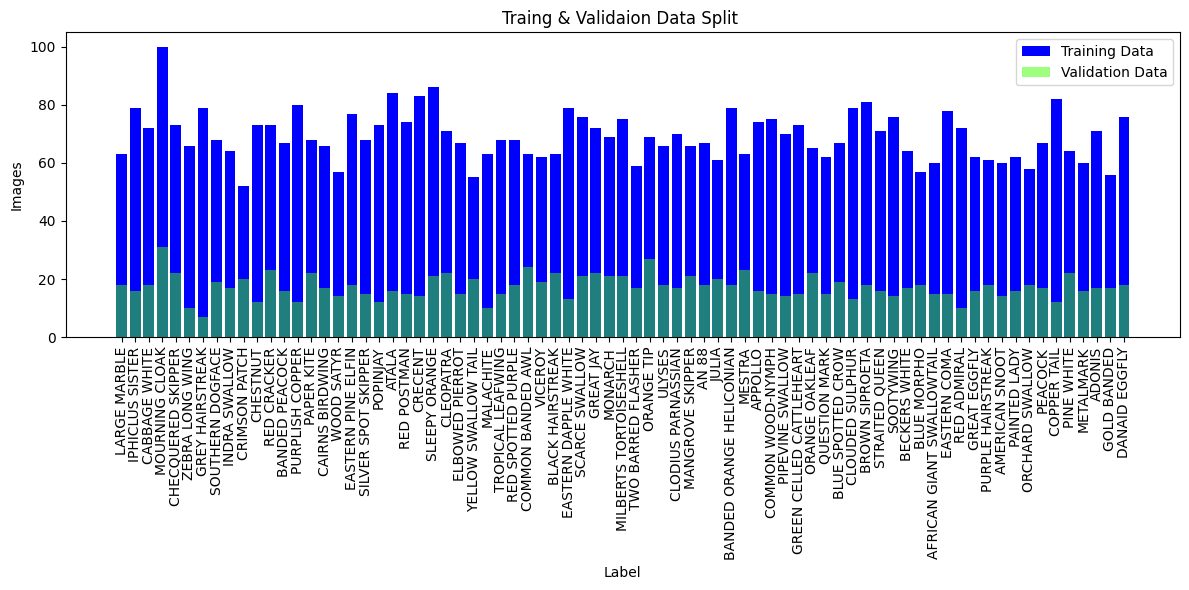

In [124]:
#visualize dataset
def count_images_per_class(image_paths, labels):
    class_counts = {}
    
    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    
    return class_counts

train_class_counts = count_images_per_class(train_paths, train_labels)
val_class_counts = count_images_per_class(val_paths, val_labels)


class_names_train = list(train_class_counts.keys())
class_counts_train = list(train_class_counts.values())

class_names_val = list(val_class_counts.keys())
class_counts_val = list(val_class_counts.values())


plt.figure(figsize=(12, 6))

# Training graph
plt.bar(class_names_train, class_counts_train, color='blue', label='Training Data')
plt.xlabel('Label')
plt.ylabel('Images')
plt.title('Training Data Class Distribution')
plt.xticks(rotation=90)

# Validation  graph
plt.bar(class_names_val, class_counts_val, color='#3EFF00', label='Validation Data', alpha=0.5)
plt.xlabel('Label')
plt.ylabel('Images')
plt.title('Traing & Validaion Data Split ')
plt.xticks(rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

In [125]:
#data frame after validation splits
val_dataframe = pd.DataFrame({'image_paths': val_paths, 'labels': val_labels})
train_dataframe = pd.DataFrame({'image_paths': train_paths, 'labels': train_labels})


In [127]:


# Create DataFrames for the splits
val_dataframe = pd.DataFrame({'image_paths': val_paths, 'labels': val_labels})
train_dataframe = pd.DataFrame({'image_paths': train_paths, 'labels': train_labels})


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_dataframe,
    x_col='image_paths',
    y_col='labels',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col='image_paths',
    y_col='labels',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

#model arch with moible net basemodel and heras hyp params
input_shape = (image_height, image_width, 3)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units, activation='relu')(x)
num_classes = train_dataframe['labels'].nunique()
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

Found 1300 validated image filenames belonging to 75 classes.
Found 5199 validated image filenames belonging to 75 classes.


In [117]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# build model for keras tuner
def build_model(hp):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units, activation='relu')(x)
    num_classes = train_dataframe['labels'].nunique()
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel',  
    project_name='butterfly_tuner'
)


tuner.search(train_generator,
             epochs=epochs,  
             validation_data=val_generator,
             callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#build model with tuner results
best_model = tuner.hypermodel.build(best_hps)
best_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_hps.get('learning_rate'))
best_model.compile(optimizer=best_optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history = best_model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=epochs,
                         callbacks=[early_stopping])


val_loss, val_accuracy = best_model.evaluate(val_generator)


best_model.save('/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel/mobilenet_tuned.keras')


Trial 3 Complete [00h 56m 07s]
val_accuracy: 0.8353846073150635

Best val_accuracy So Far: 0.9346153736114502
Total elapsed time: 03h 04m 10s
Epoch 1/10
163/163 [==============================] - 298s 2s/step - loss: 2.3895 - accuracy: 0.4982 - val_loss: 1.1447 - val_accuracy: 0.7446
Epoch 2/10
163/163 [==============================] - 293s 2s/step - loss: 0.6037 - accuracy: 0.8671 - val_loss: 0.4761 - val_accuracy: 0.8854
Epoch 3/10
163/163 [==============================] - 305s 2s/step - loss: 0.3621 - accuracy: 0.9096 - val_loss: 0.3846 - val_accuracy: 0.9054
Epoch 4/10
163/163 [==============================] - 297s 2s/step - loss: 0.2524 - accuracy: 0.9363 - val_loss: 0.3402 - val_accuracy: 0.9192
Epoch 5/10
163/163 [==============================] - 296s 2s/step - loss: 0.1840 - accuracy: 0.9536 - val_loss: 0.2814 - val_accuracy: 0.9262
Epoch 6/10
163/163 [==============================] - 265s 2s/step - loss: 0.1463 - accuracy: 0.9625 - val_loss: 0.2908 - val_accuracy: 0.9262


In [132]:

# Save the best model with its optimizer
best_model.save('/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel/mobilenet_tuned_model.h5')

# loaded_model = load_model('/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/Rivindumodel/mobilenet_tuned.keras')

# preprocess_img = ImageDataGenerator(rescale=1.0/255.0)


# img = preprocess_img.load_img('/Users/rivindu/Desktop/testbutterfly/adonis2.png', target_size=(image_height, image_width))
# img = preprocess_img.img_to_array(img)
# img = img.reshape((1,) + img.shape)

# predictions = loaded_model.predict(img)
# predicted_class = np.argmax(predictions, axis=1)


/Users/rivindu/Desktop/DL-A1/Dl-butterfly-Models/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [174]:
from tensorflow.keras.preprocessing import image
import numpy as np


input_img = '/Users/rivindu/Desktop/datasetfor-butterfly/test/Image_1027.jpg'

# Load & pre-process input image
img = image.load_img(input_img, target_size=(image_height, image_width))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  


predictions = loaded_model.predict(img)
# class_labels=['ADONIS','AFRICAN GIANT SWALLOWTAIL','AMERICAN SNOOT','AN 88','APPOLLO','ATALA','BANDED ORANGE HELICONIAN','BANDED PEACOCK','BECKERS WHITE','BLACK HAIRSTREAK','BLUE MORPHO','BLUE SPOTTED CROW',
# 'BROWN SIPROETA','CABBAGE WHITE','CAIRNS BIRDWING','CHECQUERED SKIPPER','CHESTNUT','CLEOPATRA','CLODIUS PARNASSIAN','CLOUDED SULPHUR','COMMON BANDED AWL','COMMON WOOD-NYMPH','COPPER TAIL','CRECENT',
# 'CRIMSON PATCH','DANAID EGGFLY','EASTERN COMA','EASTERN DAPPLE WHITE' ,'EASTERN PINE ELFIN','ELBOWED PIERROT','GOLD BANDED','GREAT EGGFLY','GREAT JAY','GREEN CELLED CATTLEHEART','GREY HAIRSTREAK','INDRA SWALLOW',
# 'IPHICLUS SISTER','JULIA','LARGE MARBLE','MALACHITE','MANGROVE SKIPPER','MESTRA','METALMARK','MILBERTS TORTOISESHELL','MONARCH','MOURNING CLOAK','ORANGE OAKLEAF','ORANGE TIP','ORCHARD SWALLOW','PAINTED LADY',
# 'PAPER KITE','PEACOCK','PINE WHITE','PIPEVINE SWALLOW','POPINJAY','PURPLE HAIRSTREAK','PURPLISH COPPER','QUESTION MARK','RED ADMIRAL','RED CRACKER','RED POSTMAN','RED SPOTTED PURPLE','SCARCE SWALLOW','SILVER SPOT SKIPPER','SLEEPY ORANGE','SOOTYWING',
# 'SOUTHERN DOGFACE','STRAITED QUEEN','TROPICAL LEAFWING','TWO BARRED FLASHER','ULYSES','VICEROY','WOOD SATYR','YELLOW SWALLOW TAIL','ZEBRA LONG WING'
# ]
class_labels = [
    "ADONIS",
    "AFRICAN GIANT SWALLOWTAIL",
    "AMERICAN SNOOT",
    "AN 88",
    "APPOLLO",
    "ATALA",
    "BANDED ORANGE HELICONIAN",
    "BANDED PEACOCK",
    "BECKERS WHITE",
    "BLACK HAIRSTREAK",
    "BLUE MORPHO",
    "BLUE SPOTTED CROW",
    "BROWN SIPROETA",
    "CABBAGE WHITE",
    "CAIRNS BIRDWING",
    "CHECQUERED SKIPPER",
    "CHESTNUT",
    "CLEOPATRA",
    "CLODIUS PARNASSIAN",
    "CLOUDED SULPHUR",
    "COMMON BANDED AWL",
    "COMMON WOOD-NYMPH",
    "COPPER TAIL",
    "CRECENT",
    "CRIMSON PATCH",
    "DANAID EGGFLY",
    "EASTERN COMA",
    "EASTERN DAPPLE WHITE",
    "EASTERN PINE ELFIN",
    "ELBOWED PIERROT",
    "GOLD BANDED",
    "GREAT EGGFLY",
    "GREAT JAY",
    "GREEN CELLED CATTLEHEART",
    "GREY HAIRSTREAK",
    "INDRA SWALLOW",
    "IPHICLUS SISTER",
    "JULIA",
    "LARGE MARBLE",
    "MALACHITE",
    "MANGROVE SKIPPER",
    "MESTRA",
    "METALMARK",
    "MILBERTS TORTOISESHELL",
    "MONARCH",
    "MOURNING CLOAK",
    "ORANGE OAKLEAF",
    "ORANGE TIP",
    "ORCHARD SWALLOW",
    "PAINTED LADY",
    "PAPER KITE",
    "PEACOCK",
    "PINE WHITE",
    "PIPEVINE SWALLOW",
    "POPINJAY",
    "PURPLE HAIRSTREAK",
    "PURPLISH COPPER",
    "QUESTION MARK",
    "RED ADMIRAL",
    "RED CRACKER",
    "RED POSTMAN",
    "RED SPOTTED PURPLE",
    "SCARCE SWALLOW",
    "SILVER SPOT SKIPPER",
    "SLEEPY ORANGE",
    "SOOTYWING",
    "SOUTHERN DOGFACE",
    "STRAITED QUEEN",
    "TROPICAL LEAFWING",
    "TWO BARRED FLASHER",
    "ULYSES",
    "VICEROY",
    "WOOD SATYR",
    "YELLOW SWALLOW TAIL",
    "ZEBRA LONG WING"
]

index_of_largest_value = np.argmax(predictions)
print("index_of_largest_value",index_of_largest_value)
print("predicted class",class_labels[index_of_largest_value])







1/1 [==============================] - 0s 47ms/step
index_of_largest_value 13
predicted class CABBAGE WHITE


Class Names: ['ORANGE OAKLEAF', 'VICEROY', 'MESTRA', 'CRIMSON PATCH', 'WOOD SATYR', 'RED CRACKER', 'GREAT JAY', 'BROWN SIPROETA', 'TWO BARRED FLASHER', 'METALMARK', 'GREY HAIRSTREAK', 'ZEBRA LONG WING', 'BLACK HAIRSTREAK', 'PIPEVINE SWALLOW', 'YELLOW SWALLOW TAIL', 'EASTERN DAPPLE WHITE', 'ORANGE TIP', 'GOLD BANDED', 'ULYSES', 'BLUE MORPHO', 'AFRICAN GIANT SWALLOWTAIL', 'TROPICAL LEAFWING', 'BLUE SPOTTED CROW', 'GREAT EGGFLY', 'RED ADMIRAL', 'SILVER SPOT SKIPPER', 'CRECENT', 'STRAITED QUEEN', 'SLEEPY ORANGE', 'COMMON WOOD-NYMPH', 'SOUTHERN DOGFACE', 'QUESTION MARK', 'CHESTNUT', 'LARGE MARBLE', 'EASTERN PINE ELFIN', 'RED SPOTTED PURPLE', 'PURPLE HAIRSTREAK', 'BANDED ORANGE HELICONIAN', 'PEACOCK', 'BANDED PEACOCK', 'ADONIS', 'MILBERTS TORTOISESHELL', 'MANGROVE SKIPPER', 'PINE WHITE', 'PURPLISH COPPER', 'EASTERN COMA', 'MONARCH', 'CLODIUS PARNASSIAN', 'SOOTYWING', 'MOURNING CLOAK', 'PAINTED LADY', 'APPOLLO', 'CAIRNS BIRDWING', 'PAPER KITE', 'SCARCE SWALLOW', 'CLOUDED SULPHUR', 'IPHICLUS S